# Hands-On Assignment 2

As we saw in Module 2, machine learning is about optimizing over a loss.
How well a machine learning model performs depends on both the hypothesis and loss function that we choose to use.
This general framework goes under the name of *[empirical risk minimization](https://en.wikipedia.org/wiki/Empirical_risk_minimization)*.

In this assignment, we will walk you through the basic steps of empirical risk minimization: the optimization problem at the heart of most modern-day machine learning systems.
We will use a simple motivating example for an end-to-end demonstration: predicting whether a patient with a given antigen test value is infected with Covid-19.
Using the same synthetic Covid-19 dataset you worked with in Hands-On Assignment 1,
we will train a simple [classifier](https://en.wikipedia.org/wiki/Statistical_classification)
which predicts that an individual is infected with Covid-19 if and only if their test value is above a certain threshold.

After that, we will take a break from the serious stuff and learn about regular expression
(or review regular expressions if you are already familiar).
Regular expressions are a tool that you will almost certainly find useful for your entire CS career,
and is especially useful when working with data (as you will be doing a lot).

This assignment is divided into four parts:
1. We will first set up a basic empirical risk minimization problem.
2. Next, we will find a hypothesis that results in a small loss.
3. Then, we will evaluate our solution and the associated risks of deployment.
4. Finally, we will learn about all the core features of regular expressions.

---

## Part 1: Setting up the Problem

In this part we will setup the empirical risk minimization problem we wish to solve, by:
 - Defining our variables of interest.
 - Choosing a "hypothesis class" $ \mathcal{H} $, or space of possible solutions, that we will search.
 - Selecting a "loss function" $ L $ that will be minimized by our learned solution.

### Empirical Risk Minimization - The Big Picture

Empirical risk minimization is about trying to come up with a function (usually called a *hypothesis*) that can make correct predictions as often as possible.
The more our hypothesis is correct, the lower the *risk* of that hypothesis.
A hypothesis that is always correct has zero risk.

But in real life, it's almost always impossible to make something that is always correct.
(If we could, there would be no point in machine learning.)
It's also impossible for us to always know when our hypothesis is right or wrong
(imagine trying to predict something for every person in the world (past, present, and future)).
We may know how our hypothesis performs on our small dataset,
but we can't know how it will perform on all possible data points.

So since we can't compute the true risk of a hypothesis, we instead approximate it by computing an *empirical risk*.
To do this, we narrow down our set of data points from every possible data point to a known set of data (called our "training data").
We can then compute our average loss over our training data to compute our empirical risk.

### Empirical Risk Minimization - Mathematical Formalism

Now, let's put our intuition from the previous section into math.

Empirical risk minimization is the **minimization** (over several possible hypotheses $ \mathcal{H} $) of the expected loss (i.e. *risk*) of a hypothesis $ h $ with the data $ Z $:
$$
\min_{h \in \mathcal{H}} \mathbb{E}_Z \Big[ L(Z, h) \Big]
$$
So we want to select one hypothesis $ h $ from our set of possible hypotheses $ \mathcal{H} $
that minimizes the loss (risk) we expect to achieve.

Here we are taking the [expectation](https://en.wikipedia.org/wiki/Expected_value) ($ \mathbb{E} $) over all possible values of the data.
If you haven’t seen expectation before, we will discuss it in detail in a future module.
But for now, you can think of expectation as the average value we would get if we randomly sampled infinite data points.
For example, if we fairly picked random numbers between 1 and 99 (inclusive),
then the expected value (expectation) would be 50.
You can make a small Python program to try it out yourself.

Using our training data $ Z = \{z_1, z_2, z_3, ..., z_N \} $, we can say that:
$$
\mathbb{E}_{Z} \Big[ L(Z, h) \Big] \approx \frac{1}{N} \sum_{i = 1}^N L(z_i, h)
$$

This may look intimidating,
but remember that $ L(z_i, h) $ is just a function that produces a single number.
So if we say that our loss for the ith data point is $ L(z_i, h) = l_i $,
then our equation looks like:
$$
\mathbb{E}_{Z} \Big[ l \Big] \approx \frac{1}{N} \sum_{i = 1}^N l_i
$$

Which we can see is just an average.
So the key takeaway here is that the expectation is just an average over possible outcomes
(in this case each data point is one possible outcome).

### A Motivating Example using Synthetic Covid-19 Data

As a motivating example, let's try to use the synthetic Covid-19 data used in HO1 to predict whether a patient has Covid-19.
For this task, we are given previous examples of asymptomatic patients (and their Covid-19 infection status),
and we are going to assume that these examples accurately represent patients that we may see in the future.
This assumption we are making is called the [i.i.d. assumption](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables),
and it is one of the cornerstones of many machine learning algorithms.
The independent and identically distributed (i.i.d.) assumption assumes that all random variables (each patient in this example),
are *independent* (one patient being infected does not affect whether another patient is infected),
and *identically distributed* (future patients will have similar features to the patients we have already seen).

Let's load our data, included in this repository as `synthetic_covid_data.csv`,
using Python and briefly look over its contents:

In [2]:
# Import all the libraries we will need.
import re

import matplotlib
import matplotlib.pyplot
import numpy
import pandas

# Read data from the given csv file to a Pandas DataFrame.
covid_data = pandas.read_csv('synthetic_covid_data.csv', index_col = 0)

# Show some basic column and type information.
covid_data.info()

<class 'pandas.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   infected              5000 non-null   bool   
 1   symptomatic           5000 non-null   bool   
 2   days_before_symptoms  138 non-null    float64
 3   titer                 5000 non-null   int64  
dtypes: bool(2), float64(1), int64(1)
memory usage: 88.0 KB


Inspecting the DataFrame information, we see that this dataset contains the following columns:
 - `infected` (as a boolean) - whether a patient had Covid-19.
 - `symptomatic` (as a boolean) - whether a patient developed symptoms.
 - `days_before_symptoms` (as a float) - how many days after testing the patient developed symptoms, if they did.
 - `titer` (as an integer) - how many times bodily fluids could be diluted before antigen was no longer detectable.

We also note that Pandas tells us that `days_before_symptoms` contains mostly null/undefined content (only 138 non-null values).

We can get an impression of the ranges and statistics of numerical columns by calling `covid_data.describe()`:

In [3]:
# Describe numerical column statistics.
covid_data.describe()

,days_before_symptoms,titer
count,138.000000,5000.00000
mean,5.405797,3.21480
std,3.877010,8.30552
min,0.000000,0.00000
25%,2.000000,0.00000
50%,5.000000,0.00000
75%,9.000000,1.00000
max,13.000000,45.00000


### Defining Variables of Interest: Features and Labels

The first step in empirical risk minimization is to define our features ($ X $) and labels ($ Y $).

The features (as discussed in HO1) are the meaningful numbers that we associate with a data point.
In our Covid-19 data, we have three columns that can be used as features: `symptomatic`, `days_before_symptoms`, and `titer`.
To keep things simple, we will only use one feature in this assignment: the `titer` column.
Although we will only use one feature column in this assignment, most machine learning models use tens, hundreds, thousands, or even more feature columns.

For our label, we will use the `infected` column.
A label assigns each data point to a specific class (in this case, *infected* or *not infected*).
Labels can take a wide range of values, for example if you are trying to classify the subject of an image there can be many possible labels: dog, cat, person, etc.
In this assignment we are focusing on [binary classification](https://en.wikipedia.org/wiki/Binary_classification),
where the label can only be True (1) or False (0).

Together, the features ($ X $) and labels ($ Y $) define our dataset $ Z $:
$$
Z = (X, Y)
$$

In [4]:
# Extract features and labels from the dataframe.

# Labels.
Y_values = covid_data['infected']

# Features.
X_values = covid_data['titer']

#### Briefly Interpreting the Data

In this dataset, a "titer" value roughly measures the concentration of a specific antigen produced by a Covid-19 infection,
so a higher value *generally* means a worse infection.
Having run `covid_data.describe()`, we see that titer values in this dataset are integers ranging from `0` to `45`,
with at least 75% of examples having titer values of `1` or less.
We can visualize the relationship between titer and Covid-19 infections in our data by plotting the Covid-19 infection rate vs titer values
(i.e., for each titer value, plot the percent of patients that have that titer value and are infected).

Throughout this assignment, code snippets will be provided for you.
It is strongly encouraged that you take some time and try to understand the general idea of that each snippet does.
You don't need to exactly understand what every line does,
but having a general idea will help you throughout this course.

### def plot_infection_probability_vs_titer(frame):
    """
    Plot the infected rate of Covid-19 vs titer value.
    """

    # Get all the possible titer values in a list.
    titer_values = list(range(frame['titer'].min(), frame['titer'].max() + 1))
    infected_rate = []

    for titer_value in titer_values:
        infected_count = len(frame[(frame['titer'] == titer_value) & frame['infected']])
        count = len(frame[(frame['titer'] == titer_value)])

        if (count == 0):
            # Matplotlib will ignore None/NaN values.
            infected_rate.append(None)
        else:
            infected_rate.append(infected_count / count)

    matplotlib.pyplot.plot(infected_rate)
    matplotlib.pyplot.title('Sample Frequency of Covid-19 Infection vs Titer Value')
    matplotlib.pyplot.xlabel('Titer')
    matplotlib.pyplot.ylabel('Precentage Infected')

plot_infection_probability_vs_titer(covid_data)

In the above graph we can see, perhaps surprisingly,
that many patients with low (but not zero) titer values are actually infected.
The graph shows that at a titer value of 0, we don't see any infected individuals;
at a titer value of 10, about 100% if patients are infected;
at a titer value of 20, the infection rate drops to around 20%;
and finally at a titer value of 40, the infection rate climbs back up to around 80%.
Unfortunately, biological data is rarely simple and straightforward.

To make more sense of our data, we can separate out the data into infected and uninfected individuals.
Specifically, we can see what percentage of each population (infected/uninfected) exist at each titer value.

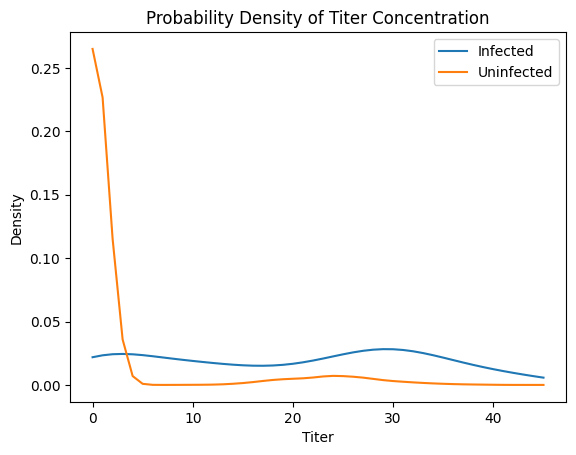

In [5]:
def plot_conditional_probability_density_functions(frame):
    """
    Plot probability density of titer value conditioned on Covid-19 infection.
    """

    titer_values = list(range(frame['titer'].min(), frame['titer'].max() + 1))
    infected = frame[frame['infected']]['titer']
    uninfected = frame[~frame['infected']]['titer']

    matplotlib.pyplot.title('Probability Density of Titer Concentration')
    matplotlib.pyplot.xlabel('Titer')
    infected.plot(kind = 'density', label = 'Infected', ind = titer_values)
    uninfected.plot(kind = 'density', label = 'Uninfected', ind = titer_values)
    matplotlib.pyplot.legend()

plot_conditional_probability_density_functions(covid_data)

Looking at this graph, we can discover some important details about our data.
While most uninfected individuals have very low titer values (under 5),
some small percentage of (isoantigenic) uninfected individuals have reasonable high titer values (widely distributed around 25).
Meanwhile, infected individuals appear to belong to two groups:
one with relatively small titer values (less than 10) and one with much higher titer values (centered around 30).

### Choosing a Hypothesis Class to Search

Now that we have explored our data, it is time to try and make predictions.

Recall that we wish to predict patients' labels $ Y = \{ y_1, y_2, ..., y_N \} $ from patients' features $ X = \{ x_1, x_2, ..., x_N \} $.
That is, our task is to predict each $ y_i $ from each $ x_i $, approximating the true mapping $ f $ such that
$$
\forall i, \quad f(x_i) \mapsto y_i
$$

Since we can never expect to find $ f $ in a real-life problem (since $ f $ is a theoretically perfect predictor),
we will use different hypotheses to approximate it.
A hypothesis is just a function that maps features to a label.
We will denote a general hypothesis with the variable $ h $.
Since we cannot guarantee our hypothesis, $ h $, is always correct,
we denote its output with $ \hat{Y} $ (pronounced "Y-hat").
We say that $ Y $ is the "true label" and $ \hat{Y} $ is the "predicted label".
$$
\forall i, \quad h(x_i) \mapsto \hat{y}_i
$$

Note that we will often relax our notation so that the input to a hypothesis function can either be a single data point ($ h(x_i) \mapsto \hat{y}_i $) or many data points ($ h(X) \mapsto \hat{Y} $).

#### An Example Hypothesis

As a simple example of a hypothesis $ h $,
we might predict $ \hat{y}_i = 1 $ if and only if $ x_i $ is odd.
It turns out that this hypothesis is correct more often than random guessing (which would yield 50% accuracy)!
But, but this doesn't really seem like a principled hypothesis for the task at hand.
We just got lucky, and could have easily picked even instead of odd.

### def is_odd(feature_value):
    """
    An example hypothesis that guesses True (1) if the input is odd.
    """

    return feature_value % 2

# Note that Pandas understands how to do "% 2" on an entire series,
# so our hypothesis function works for single values and Pandas series.
Y_predicted = is_odd(X_values)

accuracy = sum(Y_values == Y_predicted) / len(covid_data)
print(f"The accuracy of predicting Ŷ = 1 iff X is odd is {accuracy * 100}%.")

#### An Example Hypothesis Class

Having only a single possible hypothesis is not very interesting or useful.
Instead, we want to try out and evaluate multiple different hypotheses.
When we group together multiple hypotheses, we call this a *hypothesis class*, denoted by $ \mathcal{H} $.

Let's consider a class of two different hypotheses:
$ h_0 $ that predicts $ \hat{Y} = 0 $ for all examples,
and $ h_1 $ that always predicts $ \hat{Y} = 1 $.
$$
\mathcal{H} = \Big\{ h_0, h_1 \Big\}
$$
where
$$
\forall X, \quad h_0(X) = 0 \quad h_1(X) = 1
$$
Note that both of these hypotheses are independent of $ X $ ($ X $ does not affect what value the hypotheses predicts).

Now that we have two possible hypotheses,
we can conduct experiments to compare them on our data and select the hypothesis that performs the best.
Since only $ \approx $ 5% of individuals in our dataset are Covid-19 positive,
$ h_0 $ will match the true mapping $ f $ on 95% of examples (while $ h_1 $ is only correct 5% of the time).
If we decide the best hypothesis using maximum accuracy,
then $ h_0 $ will look like the best hypothesis and we will always predict that patients are not infected with Covid-19.

Obviously, this class of hypotheses is too naïve and we need a richer hypothesis space to search.

#### A Parametric Hypothesis Class

If we look back to our naïve hypothesis class $ \mathcal{H} = \{h_0, h_1\} $,
we can generalize these hypotheses a bit if recognize that both $ h_0 $ and $ h_1 $ are *threshold* classifiers.
That is, the value of each function can be expressed in terms of a comparison of $ X $ to some *threshold* value:
\begin{align*}
    h_0 = h(X) &= \begin{cases} 1 & X > \infty \\
                            0 & X \leq \infty \end{cases} \\
    h_1 = h(X) &= \begin{cases} 1 & X > -\infty \\
                            0 & X \leq -\infty \end{cases}
\end{align*}
In this case, our threshold values were the extreme ends of the spectrum: $ \infty $ and $ -\infty $.

Now what if, instead of these extreme threshold values, we choose a more meaningful value like `20`?
\begin{align*}
    h_{20} = h(X) &= \begin{cases} 1 & X > 20 \\
                          0 & X \leq 20 \end{cases}
\end{align*}

Now, we can also abstract out the specific threshold value for a variable, $ \theta $:
\begin{align*}
    h(X, \theta) &= \begin{cases} 1 & X > \theta \\
                                  0 & X \leq \theta \end{cases}
\end{align*}
We can recover all of our previous hypothesis using this more general form:
\begin{align*}
    h_0 & = h(X, \infty) \\
    h_1 & = h(X, -\infty) \\
    h_{20} & = h(X, 20)
\end{align*}

We can even apply our new general hypothesis to our Covid-19 data.
Let $h(X, \theta)$ predict that a patient is infected with Covid-19 ($ \hat{Y} = 1 $) if and only if `titer` $ X $ is above the threshold value $ \theta $:
$$
    h(X, \theta) = \begin{cases}
    1 & X > \theta  \\
    0 & X \leq \theta
    \end{cases}
$$

Since we now have a general and parameterized hypothesis function,
we can use it to define *all possible hypotheses* our function can represent.
This set of all possible hypotheses is called a "hypothesis space"
(you can think of it as a more general form of a hypothesis class).
Letting $ \theta $ be all possible real numbers, $ \mathbb{R} $, we can create our hypothesis space $ \mathcal{H} $:
$$
    \mathcal{H} = \Big\{h(\cdot, \theta) ~\colon~ \theta \in \mathbb{R} \Big\}
$$
Where the $ \cdot $ (dot) represents any input value.

Because each such threshold classifier is uniquely determined by its threshold value $\theta$, we say that this hypothesis space is *parameterized* by $\theta$.
This means that the original optimization problem may be written as an optimization over $ \theta $,
where we slightly abuse notation to rewrite $ L $ as a function of $ \theta $:
$$
\min_{h\in\mathcal{H}} \mathbb{E}_Z \Big[ L(Z, h) \Big] =  \min_{\theta} \mathbb{E}_Z \Big[ L(Z, \theta) \Big]
$$

It is very common in machine learning to choose hypothesis classes that are parameterized by numerical variables,
this makes it easier to search over with a program.

<h3 style="color: darkorange; font-size: x-large";>★ Task 1.A</h3>

Complete the function below that implements the threshold hypothesis function $ h(x, \theta) $ described above.

In [6]:
def threshold_hypothesis(feature, theta):
    """
    Our thresholding hypothesis function.
    Predict True if x > theta, and False otherwise.

    Args:
      feature: A scalar "titer" value.

    Returns:
      ŷ: A boolean.
    """

    return feature > theta

print("h(0, 1): ", threshold_hypothesis(0, 1))
print("h(1, 0): ", threshold_hypothesis(1, 0))

h(0, 1):  False
h(1, 0):  True


### Selecting a Loss Function to Minimize

In general, it is not possible to learn the true mapping of data to labels, $ f $, exactly.
In fact, there may be no $ \theta $, or no $ h \in \mathcal{H} $, such that $ h = f $.
It could even be possible that 
$ f $ is not even a true *function*!
There could be two patients with the same features but different infection labels,
making it impossible for $ f $ to actually exist.

Instead, we want to choose an $ h \in \mathcal{H} $ that closely approximates the true mapping $ f $.
Mathematically, we introduce a ["loss" function](https://en.wikipedia.org//wiki/Loss_function) that imposes some
[divergence](https://en.wikipedia.org/wiki/Divergence_(statistics)) between $ h $ and $ f $ and seek to minimize this loss.
Essentially, we want a function (a loss function) that can tell us how well a hypothesis performs
(higher loss values are typically bad and a zero loss means our hypothesis matches the data exactly).
Minimizing a loss function is the central task in [mathematical optimization](https://en.wikipedia.org/wiki/Mathematical_optimization),
and is thus central to machine learning.

Though the world of loss functions is vast and theoretically rich,
one simple loss function for binary classifiers is "Zero-One" loss.
Zero-One loss outputs a zero loss (score) when our hypothesis, $ h $, and the true label mapping, $ f $, agree on a given example $ (x_i, y_i) $,
and a one loss (score) otherwise.
(For each data points we get a 0 if we are right and a 1 if we are wrong.)
$$
    L(Z, \theta) = \begin{cases}
    0 & h(X, \theta) = Y \\
    1 & \text{otherwise}
    \end{cases}
$$

Minimizing Zero-One loss corresponds to maximizing the accuracy of a binary predictor, i.e.,
minimizing the number of times our hypothesis disagrees with the true labels makes our predictor better.

<h3 style="color: darkorange; font-size: x-large";>★ Task 1.B</h3>

Complete the function below which computes the Zero-One loss for the given hypothesis and theta on the given example.

Note here how we are passing a function (`hypothesis`) into the function we are creating (`zero_one_loss`).
Python has no trouble passing around functions (methods are a little harder).
We will be passing functions as arguments a lot in this assignment.
At first it may seem strange to pass functions instead of just calling them directly,
but this will give your code a lot more flexibility.
For example, when grading we can use our own implementations of the passed in functions
and grade you even if you skip a part (so messing up earlier on will not impact your grade for later parts).
So, if you accidentally mess up `threshold_hypothesis`,
that will not impact your grade for `zero_one_loss`.

In [7]:
def zero_one_loss(feature, label, hypothesis, theta):
    """
    Zero-One Loss on a single example (feature, label), as a function of hypothesis and theta.

    Args:
      feature: A scalar "titer" value.
      label: A boolean value corresponding to actual Covid-19 infection.
      hypothesis: A function of (x, theta) that maps to predicted boolean label ŷ.
      theta: A scalar titer threshold.

    Returns:
      0 or 1
    """
    h = hypothesis(feature, theta)
    if h == label:
        return 0
    return 1

loss = zero_one_loss(0, True, threshold_hypothesis, 1)
print("What's the loss for h(0, 1) with a positive label?: ", loss)

loss = zero_one_loss(1, True, threshold_hypothesis, 0)
print("What's the loss for h(1, 0) with a positive label?: ", loss)

What's the loss for h(0, 1) with a positive label?:  1
What's the loss for h(1, 0) with a positive label?:  0


---

## Part 2: Solving the Problem

Now that we have formalisms for hypotheses and loss functions,
we will work on finding the best hypothesis/parameters to solve our problem.
The first step will be to evaluate how well a hypothesis and parameter are performing according to our loss function on our data.
To do that, we can compute an expected loss (the mean loss over all data points):
$$
\mathbb{E}_{Z} \Big[ L(Z, h, \theta) \Big] = \frac{1}{N} \sum_{i = 1}^N L(z_i, h, \theta)
$$

<h3 style="color: darkorange; font-size: x-large";>★ Task 2.A</h3>

Complete the function below which calculates the expected (average) loss on the given examples (`features` and `labels`) as a function of the hypothesis and $ \theta $.

In [8]:
def expected_loss(features, labels, loss_function, hypothesis, theta):
    """
    Evaluates the average loss of the given hypothesis/theta over all examples.

    Args:
      features: the column of X feature (titer) values from empirical data.
      labels: the column of Y label (infection) values from empirical data.
      loss_function: A loss function.
      hypothesis: A function of (x, theta) that maps to the predicted label ŷ.
      theta: A scalar titer threshold.

    Returns:
      A scalar.
    """
    losses = []
    ans = 0
    for feature, label in zip(features, labels):
        losses.append(loss_function(feature, label, hypothesis, theta))
    return sum(losses) / len(losses)

features = [-1, -1, 1, 1]
labels = [True, False, True, False]
loss = expected_loss(features, labels, zero_one_loss, threshold_hypothesis, 0)
print("Expected Loss: ", loss)

Expected Loss:  0.5


Since our example is simple, we can visualize the "loss landscape" (loss as a function of $ \theta $) directly.

**The following step depends on previous tasks.**

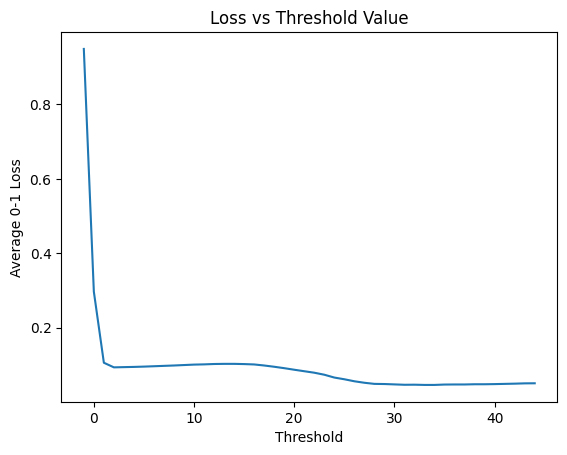

In [9]:
# Possible threshold values (e.g. possible titer values).
possible_thetas = list(range(X_values.min() - 1, X_values.max()))

def check_implemented_for_plotting(loss_function, expected_loss, hypothesis):
    """
    Raise a special exception if the code has not been implemented yet.
    Catching this exception allows us to
    gracefully handle tasks that have not yet been implemented
    (instead of just crashing).
    """
    
    if (hypothesis(0, 1) == NotImplemented):
        raise NotImplementedError("Hypothesis (%s) not yet implemented." % (
            hypothesis.__name__))

    if (loss_function(0, True, hypothesis, 1) == NotImplemented):
        raise NotImplementedError("Loss function (%s) not yet implemented." % (
            loss_function.__name__))

    if (expected_loss([0], [True], loss_function, hypothesis, 0) == NotImplemented):
        raise NotImplementedError("Expected loss function (%s) not yet implemented." % (
            expected_loss.__name__))

def evaluate_losses(features, labels, loss_function, expected_loss, hypothesis):
    """
    Return a list of expected losses mapped from a list of possible theta values.
    """

    # Test if the provided code has been implemented yet.
    check_implemented_for_plotting(loss_function, expected_loss, hypothesis)
    
    # Empirical loss for each threshold value.
    losses = []
    for theta in possible_thetas:
        losses.append(expected_loss(features, labels, loss_function, hypothesis, theta))

    return losses

def plot_loss_landscape():
    """
    Plot expected loss vs threshold value.
    """

    matplotlib.pyplot.plot(possible_thetas, evaluate_losses(X_values, Y_values,
                                                 zero_one_loss, expected_loss,
                                                 threshold_hypothesis))
    matplotlib.pyplot.title('Loss vs Threshold Value')
    matplotlib.pyplot.xlabel('Threshold')
    matplotlib.pyplot.ylabel('Average 0-1 Loss')

try:
    plot_loss_landscape()
except NotImplementedError as ex:
    print("Cannot run plotting function: ", ex)

Again, since our example is simple, we may find the loss-minimizing value of $\theta$ by performing a direct search.

### Brute-Force Search

There are many optimization algorithms used in machine learning, each with countless tweaks and variations.
One of the more famous methods, gradient descent, we will learn about later in this course.
Nonetheless, **many** optimization algorithms are applicable to our current problem of empirical risk minimization;
in some cases, more principled algorithms (such as convex optimization methods) will give better results, depending on the structure of the problem.
To focus on the conceptual underpinnings of empirical risk minimization, here we will start with the simplest of algorithms: brute-force search.
That is, we will compare all possible hypotheses (values of theta) and select the one that minimizes empirical loss.
A brute force search is not always possible (like when there are infinite thetas), but in our specific case there are only so many possible integer titer values.

<h3 style="color: darkorange; font-size: x-large";>★ Task 2.B</h3>

Complete the function below which calculates the index of the minimum of a given loss:

In [10]:
def index_of_minimum(list_of_values):
    """
    Return the index of minimum value from a list of values.
    If there are multiple items that share the same minimum value,
    then return the lowest index.

    Args:
      list_of_values: A list or array.

    Return:
      An integer index or None if the list is empty.
    """

    return list_of_values.index(min(list_of_values))

my_list = [1, 2, 3]
print("Index of min of %s: %s." % (my_list, index_of_minimum(my_list)))

my_list = [3, 2, 1]
print("Index of min of %s: %s." % (my_list, index_of_minimum(my_list)))

Index of min of [1, 2, 3]: 0.
Index of min of [3, 2, 1]: 2.


### Result: Learned Threshold Value

According to the average Zero-One loss, what is the optimal threshold titer above which to predict an individual has Covid-19?
The function bellow will finally answer this question.

**This step depends on the previous tasks.**

In [11]:
def check_implemented_for_brute_force(hypothesis, loss_function, expected_loss, index_of_minimum):
    """
    Raise a special exception if the code has not been implemented yet.
    Catching this exception allows us to
    gracefully handle tasks that have not yet been implemented
    (instead of just crashing).
    """

    check_implemented_for_plotting(loss_function, expected_loss, hypothesis)
    
    if (index_of_minimum([0]) == NotImplemented):
        raise NotImplementedError("Index of minimum function (%s) not yet implemented." % (
            index_of_minimum.__name__))

def brute_force_minimize(possible_thetas, index_of_minimum, features, labels,
                         loss_function, expected_loss, hypothesis):
    check_implemented_for_brute_force(hypothesis, loss_function, expected_loss, index_of_minimum)
                                 
    best_index = index_of_minimum(evaluate_losses(features, labels, loss_function,
                                                  expected_loss, hypothesis))
    return possible_thetas[best_index]

try:
    min_value = brute_force_minimize(
        possible_thetas, index_of_minimum,
        X_values, Y_values, zero_one_loss, expected_loss, threshold_hypothesis
    )
    print("Optimal threshold theta for raw accuracy: ", min_value)
except NotImplementedError as ex:
    print("Cannot run brute force minimization: ", ex)

Optimal threshold theta for raw accuracy:  33


Go back and compare this value to our graph that plots loss against threshold.
Does this value match up with the graph?

---

## Part 3: Assessing Risk

In this part, we will learn how to evaluate our solution and consider the associated risks of deployment.
In general, each of the steps we went through in previous parts are non-trivial and raises questions that are the subject of active research.
For example:
 - Is our selection of variables appropriate, or do they induce bias in our predictor?
 - What loss functions naturally encode our objectives? Which have mathematical advantages? Which introduce systematic risks?
 - What algorithms are effective in which settings, and what theoretical results can we prove regarding speed, efficiency, or safety?
 - How do we use existing data effectively, again without introducing bias or systemic errors in our solutions?
 - Can our algorithms scale to larger datasets?
 - Can we choose algorithms that can guarantee our results are good enough?

While we have found the threshold titer value that minimizes Zero-One loss and therefore maximizes accuracy,
accuracy (especially evaluated only on the data used for training) is not necessarily the best quantity to optimize.
For example, our Covid-19 data only has about 5% of patients that are infected.
Predicting False for all data points would give an accuracy of 95%.
The accuracy may be high, but the predictor is useless.

Additionally, sometimes we care about certain types of errors more than others.
Consider the following use for our titer-threshold classifier: we wish to screen visitors for entry to a ward of immunocompromised patients.
If our classifier makes a mistake, we would rather it error on the side of caution and predict that someone has Covid-19 when they actually do not.
This way even if we made an error, we protected the immunocompromised patients.
In this example, optimizing for accuracy alone is not the best measure of utility.

### Binary Classification Errors

For binary classifiers, there are several types of prediction outcomes that comprise a "contingency table" or [Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix) and which are worthy of dedicated names:

<center><img src="confusion-matrix.png"/></center>
<center style='font-size: small'>Image courtesy of <a href='https://en.wikipedia.org/wiki/Confusion_matrix'>Wikipedia</a></center>

 - True Positives (TP) -- Also called a "hit". Represent instances that were correctly classified as positive/true.
 - True Negatives (TN) -- Also called a "correct rejection". Represent instances that were correctly classified as negative/false.
 - False Positives (FP) -- Also called a "Type I Error" or "false alarm". Represent instances that were incorrectly classified as positive/true.
 - False Negatives (FN) -- Also called a "Type II Error" or "miss". Represent instances that were incorrectly classified as negative/false.

From a confusion matrix, there are many different metrics you can compute
(all telling you different things about your classifier and the dataset):

| Metric                     | Definition                   |
| -------------------------- | ---------------------------- |
| True Positive Fraction     | $$ \Pr(\hat{Y}=1, Y=1)   $$  |
| False Positive Fraction    | $$ \Pr(\hat{Y}=1, Y=0)   $$  |
| True Negative Fraction     | $$ \Pr(\hat{Y}=0, Y=0)   $$  |
| False Negative Fraction    | $$ \Pr(\hat{Y}=0, Y=1)   $$  |
| True Positive Rate         | $$ \Pr(\hat{Y}=1 \mid Y=1) $$   |
| False Positive Rate        | $$ \Pr(\hat{Y}=1 \mid Y=0) $$   |
| True Negative Rate         | $$ \Pr(\hat{Y}=0 \mid Y=0) $$   |
| False Negative Rate        | $$ \Pr(\hat{Y}=0 \mid Y=1) $$   |

Let's walk through some of these metrics.

"True Positive Fraction" ($ \Pr(\hat{Y}=1, Y=1) $) is the probability that both our prediction, $ \hat{Y} $, and true label, $ Y $, are positive/true/1.
Therefore, it would be the number of true positives over the total number of samples:
$$
\mathrm{True Positive Fraction} = TP / (P + N)
$$

"True Positive Rate" ($ \Pr(\hat{Y}=1 | Y=1) $) is the probability that the predicted label, $ \hat{Y} $, is positive *given* (conditioned on) the true label being positive.
Therefore, it would be the number of true positives over the total number actual positives:
$$
\mathrm{True Positive Rate} = TP / (TP + FN)
$$

Be aware that most of these metrics have different names in different fields.
For example, "True Positive Rate" is also called "recall", "sensitivity", and "probability of detection".

<h3 style="color: darkorange; font-size: x-large";>★ Task 3.A</h3>

Complete the following functions, which calculate the frequencies of certain outcomes for a titer-threshold classifier on our empirical data.
Refer to the above table and descriptions.
Feel free to create any supporting/helper functions you need.

In [12]:
def true_positive_fraction(features, labels, hypothesis, theta):
    """
    Returns Pr(Ŷ = 1, Y = 1) for the given hypothesis and theta.

    Args:
      features: the column of X feature (titer) values from empirical data.
      labels: the column of Y label (infection) values from empirical data.
      hypothesis: A function of (x, theta) that maps to the predicted label ŷ.
      theta: A scalar titer threshold.

    Return:
      A float.
    """
    ans = 0
    for feature, label in zip(features,labels):
        if hypothesis(feature, theta) == label:
            ans++

    return NotImplemented

def false_positive_fraction(features, labels, hypothesis, theta):
    """
    Returns Pr(Ŷ = 1, Y = 0) for the given hypothesis and theta.

    Args:
      features: the column of X feature (titer) values from empirical data.
      labels: the column of Y label (infection) values from empirical data.
      hypothesis: A function of (x, theta) that maps to the predicted label ŷ.
      theta: A scalar titer threshold.

    Return:
      A float.
    """

    return NotImplemented

def true_negative_fraction(features, labels, hypothesis, theta):
    """
    Returns Pr(Ŷ = 0, Y = 0) for the given hypothesis and theta.

    Args:
      features: the column of X feature (titer) values from empirical data.
      labels: the column of Y label (infection) values from empirical data.
      hypothesis: A function of (x, theta) that maps to the predicted label ŷ.
      theta: A scalar titer threshold.

    Return:
      A float.
    """

    return NotImplemented

def false_negative_fraction(features, labels, hypothesis, theta):
    """
    Returns Pr(Ŷ = 0, Y = 1) for the given hypothesis and theta.

    Args:
      features: the column of X feature (titer) values from empirical data.
      labels: the column of Y label (infection) values from empirical data.
      hypothesis: A function of (x, theta) that maps to the predicted label ŷ.
      theta: A scalar titer threshold.

    Return:
      A float.
    """

    return NotImplemented

features = [-1, -1, 1, 1]
labels = [True, False, True, False]
functions = [
    true_positive_fraction,
    false_positive_fraction,
    true_negative_fraction,
    false_negative_fraction,
]

for function in functions:
    value = function(features, labels, threshold_hypothesis, 0)
    print("Result of '%s': %s." % (function.__name__, value))

SyntaxError: invalid syntax (1483642172.py, line 17)

<h3 style="color: darkorange; font-size: x-large";>★ Task 3.B</h3>

Complete the following functions, which calculate the frequencies of certain outcome rates for a titer-threshold classifier on our empirical data.
Return `numpy.nan` if the desired quantity is undefined.

Feel free to use the function that you made in the previous task.
(If you made any super sweet helper functions there, its also fine to use those instead of the task functions.)

In [ ]:
def true_positive_rate(features, labels, hypothesis, theta):
    """
    Returns Pr(Ŷ = 1 | Y = 1) or numpy.nan (if the result is undefined)
    for the given hypothesis and theta.

    Args:
      features: the column of X feature (titer) values from empirical data.
      labels: the column of Y label (infection) values from empirical data.
      hypothesis: A function of (x, theta) that maps to the predicted label ŷ.
      theta: A scalar titer threshold.

    Return:
      A float or numpy.nan.
    """

    return NotImplemented

def false_positive_rate(features, labels, hypothesis, theta):
    """
        Returns Pr(Ŷ = 1 | Y = 0) or numpy.nan (if the result is undefined)
        for the given hypothesis and theta.

    Args:
      features: the column of X feature (titer) values from empirical data.
      labels: the column of Y label (infection) values from empirical data.
      hypothesis: A function of (x, theta) that maps to the predicted label ŷ.
      theta: A scalar titer threshold.

    Return:
      A float or numpy.nan.
    """

    return NotImplemented

def true_negative_rate(features, labels, hypothesis, theta):
    """
    Returns Pr(Ŷ = 0 | Y = 0) or numpy.nan (if the result is undefined)
    for the given hypothesis and theta.

    Args:
      features: the column of X feature (titer) values from empirical data.
      labels: the column of Y label (infection) values from empirical data.
      hypothesis: A function of (x, theta) that maps to the predicted label ŷ.
      theta: A scalar titer threshold.

    Return:
      A float or numpy.nan.
    """

    return NotImplemented

def false_negative_rate(features, labels, hypothesis, theta):
    """
    Returns Pr(Ŷ = 0 | Y = 1) or numpy.nan (if the result is undefined)
    for the given hypothesis and theta.

    Args:
      features: the column of X feature (titer) values from empirical data.
      labels: the column of Y label (infection) values from empirical data.
      hypothesis: A function of (x, theta) that maps to the predicted label ŷ.
      theta: A scalar titer threshold.

    Return:
      A float or numpy.nan.
    """

    return NotImplemented

features = [-1, -1, 1, 1]
labels = [True, False, True, False]
functions = [
    true_positive_rate,
    false_positive_rate,
    true_negative_rate,
    false_negative_rate,
]

for function in functions:
    value = function(features, labels, threshold_hypothesis, 0)
    print("Result of '%s': %s." % (function.__name__, value))

### The ROC Curve

One way to visualize the trade-offs between different types of binary classification errors is to plot the "Receiver Operating Characteristics" (ROC) (the name comes from using radar to classify incoming planes) of the classifier.
ROC curves have true positive rate on the y-axis and false positive rate on the x-axis.
<center><img src="roc-curve.png"/></center>
<center style='font-size: small'>Image courtesy of <a href='https://en.wikipedia.org/wiki/File:Roc_curve.svg'>Wikimedia Commons</a></center>

Intuitively, you can look at an ROC curve as how well your classifier performs as you move a threshold value.
Starting at the origin of the x-axis, we have a zero false positive rate.
This means that our classifier is very strict about predicting positive labels.
But as we move along the x-axis, the false positive rate increases.
Therefore, we get to see how our classifier performs as we become less and less strict about predicting positive labels.

In general, the more area under the ROC curve, the better.
In fact, there is a metric that just calculates the area under an ROC curve: [Area Under the ROC Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve) (AUC or AuROC for short).

**This step depends on most of the previous tasks.**

In [ ]:
def check_implemented_for_auc(true_positive_rate, false_positive_rate, hypothesis):
    """
    Raise a special exception if the code has not been implemented yet.
    Catching this exception allows us to
    gracefully handle tasks that have not yet been implemented
    (instead of just crashing).
    """
    
    if (hypothesis(0, 1) == NotImplemented):
        raise NotImplementedError("Hypothesis (%s) not yet implemented." % (
            hypothesis.__name__))

    if (true_positive_rate([0], [True], hypothesis, 0) == NotImplemented):
        raise NotImplementedError("True positive rate function (%s) not yet implemented." % (
            true_positive_rate.__name__))

    if (false_positive_rate is not None):
        if (false_positive_rate([0], [True], hypothesis, 0) == NotImplemented):
            raise NotImplementedError("False positive rate function (%s) not yet implemented." % (
                false_positive_rate.__name__))

def plot_roc(true_positive_rate, false_positive_rate, features, labels, hypothesis):
    """
    Plot the receiver operating characteristics (true positive rate vs false positive rate)
    for a given parametric hypothesis class and dataset.
    """

    check_implemented_for_auc(true_positive_rate, false_positive_rate, hypothesis)
    
    tpr = [
        true_positive_rate(features, labels, hypothesis, theta)
        for theta in possible_thetas
    ]

    fpr = [
        false_positive_rate(features, labels, hypothesis, theta)
        for theta in possible_thetas
    ]

    min_theta = numpy.min(possible_thetas)
    max_theta = numpy.max(possible_thetas)

    color = matplotlib.cm.gist_earth(
        (possible_thetas - min_theta) / (max_theta - min_theta)
    )

    ax = matplotlib.pyplot.gca()
    for i in numpy.arange(len(possible_thetas) - 1):
        ax.plot([fpr[i], fpr[i + 1]], [tpr[i], tpr[i + 1]], c=color[i])

    cbar = matplotlib.pyplot.colorbar(
        matplotlib.cm.ScalarMappable(
            norm=matplotlib.colors.Normalize(min_theta, max_theta), cmap=matplotlib.cm.gist_earth
        ),
        ax=ax,
    )

    cbar.set_label("Threshold (theta)")
    matplotlib.pyplot.title("Receiver Operating Characteristics of Threshold Classifier")
    matplotlib.pyplot.xlabel("False Positive Rate")
    matplotlib.pyplot.ylabel("True Positive Rate")

try:
    plot_roc(true_positive_rate, false_positive_rate, X_values, Y_values, threshold_hypothesis)
except NotImplementedError as ex:
    print("Cannot run ROC plotting function: ", ex)

### Precision-Recall Curve

Another useful way to visualize the trade-offs between different types of binary classification errors is to plot the "Precision-Recall Curve",
where "recall" is another name for true positive rate and "precision" is
$$
\Pr(Y{=}1 \mid \hat{Y}{=}1)
$$
Precision-recall curves have precision on the y-axis and recall on the x-axis.
Like ROC curves, they give us a way to visualize the trade-off between two different metrics.

Also like ROC, more area under the curve is better and there is a metric for how much area is under the curve: Area Under the Precision-Recall Curve (AuPRC).

**This step depends on most of the previous tasks.**

In [ ]:
def precision(features, labels, hypothesis, theta):
    """
    Returns Pr(Y = 1 | Ŷ = 1) or numpy.nan if undefined for given hypothesis and theta.
    """

    tp = true_positive_fraction(features, labels, hypothesis, theta)
    fp = false_positive_fraction(features, labels, hypothesis, theta)

    pp = tp + fp

    if (pp == 0):
        return numpy.nan

    return tp / pp

def plot_precision_recall(true_positive_rate, precision, features, labels, hypothesis):
    """
    Plot precision vs recall (positive predictive value vs true positive rate)
    for a given parametric hypothesis class and dataset.
    """

    check_implemented_for_auc(true_positive_rate, None, hypothesis)
    
    tpr = [
        true_positive_rate(features, labels, hypothesis, theta)
        for theta in possible_thetas
    ]
    pp = [precision(features, labels, hypothesis, theta) for theta in possible_thetas]

    min_theta = numpy.min(possible_thetas)
    max_theta = numpy.max(possible_thetas)

    color = matplotlib.cm.gist_earth(
        (possible_thetas - min_theta) / (max_theta - min_theta)
    )

    ax = matplotlib.pyplot.gca()
    for i in numpy.arange(len(possible_thetas) - 1):
        ax.plot([tpr[i], tpr[i + 1]], [pp[i], pp[i + 1]], c=color[i])

    cbar = matplotlib.pyplot.colorbar(
        matplotlib.cm.ScalarMappable(
            norm=matplotlib.colors.Normalize(min_theta, max_theta), cmap=matplotlib.cm.gist_earth
        ),
        ax=ax,
    )

    cbar.set_label("Threshold (theta)")
    matplotlib.pyplot.title("Precision Recall Curve for Threshold Classifier")
    matplotlib.pyplot.xlabel("True Positive Rate")
    matplotlib.pyplot.ylabel("Positive Predictive Value")

try:
    plot_precision_recall(true_positive_rate, precision, X_values, Y_values, threshold_hypothesis)
except NotImplementedError as ex:
    print("Cannot run ROC plotting function: ", ex)

In general, the use of plots such as the ROC or Precision vs Recall curve is highly contextual.
For our purposes, these curves provide a useful demonstration of a truism in machine learning: there are always consequences and trade-offs.
In particular, if we think of a high true positive rate as a "good thing" while a high false positive rate is a "bad thing",
the ROC demonstrates that perfect classifiers (which would reside in the upper left corner of the ROC diagram and upper right corner of the PRC diagram) seldom exist,
and that the space is characterized by an explicit trade-off between desirable classifier behaviors.

Note that the optimal threshold value we found for accuracy is not the optimal threshold value as represented on the ROC or Precision vs Recall Curve!
Even this basic binary classification example reveals a plethora of non-trivial trade-offs.

Welcome to machine learning!

Now let's move on to something less dense ...

---

## Part 4: Regular Expressions

[Regular expressions](https://en.wikipedia.org/wiki/Regular_expression) (also called "regexp" or "regex") are patterns that let you find matching text.
Think of them like mathematical expressions for text (an equation can define a line (collection of points), and a regex can define a collection of strings).
When starting off, regular expressions can be pretty confusing.
But once you get comfortable using them, you start to see how they can be used in almost all of your everyday coding.

<center><img src="xkcd-regular-expressions.png"/ width=600px></center>
<center style='font-size: small'>Comic courtesy of <a href='https://xkcd.com/208'>xkcd</a></center>

Aside from this assignment, here are some resources on regular expressions that you may find helpful:
 - [Text Tutorial](https://www.sitepoint.com/learn-regex/)
 - [Video Tutorial](https://www.youtube.com/watch?v=sa-TUpSx1JA)
 - [Cheat Sheet](https://cheatography.com/davechild/cheat-sheets/regular-expressions/)
 - [Regex Playground](https://regex101.com/) (Interactively create, test, and visualize regular expressions.)
 - [Python Regex Tutorial](https://docs.python.org/3/howto/regex.html)

When working with regular expressions, make sure to take your time.
Treat a regular expression as a dense piece of code.
You don't expect to look at a code file and understand everything right away,
you take things piece by piece.
Do the same thing with regular expressions,
take it slow and look at them piece by piece.

### Regular Expressions in Python

We will be using Python for this exercise (hence the iPython notebook),
so we will be using the `re` Python standard library.
Almost every major programming language has regular expressions either built-in directly or supported in a standard library.
There may be slight variations in the syntax and semantics from language to language,
but the core functionality will all be the same.

#### re.search()

In this assignment (and probably most of your Python regex usage),
we will be using the method `re.search()`.
`re.search()` takes two required arguments,
first the regex and then the string to search in (we will often call this the "target").

There is another method `re.match()` that is subtly different,
and you will probably want to avoid.
`re.search()` looks for a match within a string (and it can be the entire string).
`re.match()` tries to match **the beginning** of a string (and that can mean the entire string).
Later in this assignment, we will discuss how to recreate the functionality of `re.match()`
in a more explicit and less error-pone way.

#### "Normal" Characters

The most simple regular expressions can be used to match strings in the same way that you would use another string to match a string
(like if you were using [`str.find()`](https://docs.python.org/3/library/stdtypes.html#str.find) or [`str.replace()`](https://docs.python.org/3/library/stdtypes.html#str.replace)).
Just type the characters that you want to match.
In fact, in Python strings are used to represent regular expressions.
So most strings are already regular expressions
(but arbitrary strings may contain special symbols which are not valid regular expressions).

For example, the string `"foo"` can be used as a regular expression to match "foo", "food", "foo bar",
and literally infinite other strings that have “foo” as a substring.

In [16]:
# The regex 'foo' matches the word 'foo' in the target.
target = "What is 'foo bar'?"
regex = 'foo'
print(re.search(regex, target))

# The regex 'dog' matches 'dogs'.
target = "dogs, cats, lizards"
regex = 'dog'
print(re.search(regex, target))

# Numbers are fine too.
target = "0123456789"
regex = '45'
print(re.search(regex, target))

# The entire target string can be matched.
target = "This string is a regex"
regex = "This string is a regex"
print(re.search(regex, target))

# Here we do not match, and None is returned from re.search().
target = "abc"
regex = "123"
print(re.search(regex, target))

<re.Match object; span=(9, 12), match='foo'>
<re.Match object; span=(0, 3), match='dog'>
<re.Match object; span=(4, 6), match='45'>
<re.Match object; span=(0, 22), match='This string is a regex'>
None


#### Special Characters

There are a few special characters that you will need to be aware of.
Here is a list of them, each of which will be discussed somewhere in this assignment:

 - `.`
 - `^`
 - `$`
 - `*`
 - `+`
 - `?`
 - `{`
 - `}`
 - `[`
 - `]`
 - `\`
 - `|`
 - `(`
 - `)`

When you want to match one of these characters literally, you will need to escape it with a backslash (`\`).

#### Raw Strings

When writing regular expressions in Python, you will probably want to use a ["raw string"](https://docs.python.org/3/reference/lexical_analysis.html#escape-sequences).
Raw strings do not interpret escape characters, so you don't have to double escape backslashes or accidentally create escape characters.

In [17]:
string = 'A literal backslash: "\\"'
raw_string = r'A literal backslash: "\"'

print("string:     ", string)
print("raw string: ", raw_string)
print(string == raw_string)

string:      A literal backslash: "\"
raw string:  A literal backslash: "\"
True


To test your understanding of the concepts throughout this assignment,
we will use a game called "Regex Golf".
In Regex Golf, you have will have two sets of strings.
You want to match all the strings in the first list, while not matching all the string in the second list.

In [18]:
def regex_golf(regex, match_list = [], nomatch_list = []):
    errors = []

    if ((regex is None) or (regex == '')):
        print("Error: No regex provided.")
        return False
    
    for match_value in match_list:
        match = re.search(regex, match_value)
        if (match is None):
            errors.append("Error: Failed to match '%s'." % (match_value))
    
    for nomatch_value in nomatch_list:
        match = re.search(regex, nomatch_value)
        if (match is not None):
            errors.append("Error: Incorrectly matched '%s'." % (nomatch_value))

    if (len(errors) == 0):
        print("Great job!")
        return True
    else:
        print("You have some golfing errors, try again.")
        for error in errors:
            print("    " + error)
        return False

In [19]:
matches = [
    'foo',
    'foorbar',
    'football'
]

nomatches = [
    'forty',
    'FOO',
    'bar',
    '123',
]

regex = r'foo'
regex_golf(regex, matches, nomatches)

Great job!


True

<h4 style="color: darkorange; font-size: x-large">★ Task 4.A: My First Match</h4>

Write a regular expression (assigned in the `TASK4A_REGEX` variable) that matches the sequence "cat" (all lowercase).
Note that you don't have to match the entire string, just a part of it.

A small golfing instance is provided to get you started, but the autograder will check more cases.

In [20]:
# Put your Task 4.A regular expression here.
TASK4A_REGEX = r'cat'

cats = ['cat', 'cats', 'some cat', 'categories']
non_cats = ['dog', 'cta']
regex_golf(TASK4A_REGEX, match_list = cats, nomatch_list = non_cats)

Great job!


True

### Character Classes

Character classes allow us to refer to any **single** character inside of a set of characters.
Most regex language/engines will have built-in character classes,
and also the ability to define custom character classes.

#### Digits

The built-in digit character class is `\d`, and will match any single digit (0-9).
The inverse class (not a digit) is also available using `\D`.
`\d` and `\D` do not overlap and together match everything,
this will be true for most of the character classes we will cover.

In [ ]:
digits = ['0', '1', '2', '9']
non_digits = ['a', 'Z', '-', '!', ' ']

# Try out the digit character class.
regex = r'\d'
regex_golf(regex, match_list = digits, nomatch_list = non_digits)

# Now switch up the lists, and use the "non-digit" character class.
regex = r'\D'
regex_golf(regex, match_list = non_digits, nomatch_list = digits)

#### "Word" Characters

"Word" characters are `a-z`, `A-Z`, `0-9`, and `_` (underscore),
and are all included in the "word" character class: `\w`.
So this includes all ASCII letters, digits, and underscore.
Like the digit character class, you can get the inverse class (not a word) using `\W`.

In [ ]:
words = ['a', 'Z', '1', '0', '_']
non_words = ['-', '!', ' ']

# Try out the word character class.
regex = r'\w'
regex_golf(regex, match_list = words, nomatch_list = non_words)

# Now switch up the lists, and use the "non-word" character class.
regex = r'\W'
regex_golf(regex, match_list = non_words, nomatch_list = words)

<h4 style="color: darkorange; font-size: x-large";>★ Task 4.B: License Plates</h4>

Write a regular expression (assigned in the `TASK4B_REGEX` variable) that matches standard (non-custom) California license plates within some string.
A CA license plate has the pattern:
a number, three word characters, and three numbers (seven characters in total).

You may assume that:
 - All digits/letters are used in license plates, **including** underscores '_' and upper/lower case letters.
 - Numbers and underscores count as word characters (even though the DMV does not agree).

A small golfing instance is provided to get you started, but the autograder will check more cases.

In [ ]:
# Put your Task 4.B regular expression here.
TASK4B_REGEX = r'\d\w\w\w\d\d\d'

plates = ['1ABC123', '0xyz987', '1234567']
non_plates = ['123', 'abcdefg']
regex_golf(TASK4B_REGEX, match_list = plates, nomatch_list = non_plates)

#### Whitespace

There is also a character class to match whitespace: `\s`.
Whitespace in this context includes characters like spaces, tabs, newlines, carriage returns, etc.
The inverse class (not whitespace) is available as `\S`.

In [ ]:
# You may not be familiar with all of these whitespace character
# (since we don't typically use half of them).
# These are: [space, tab, newline, carriage return, line feed, vertical tab].
whitespace = [' ', '\t', '\n', '\r', '\f', '\v']
non_whitespace = ['a', 'Z', '1', '0', '_', '-', '!']

# Try out the whitespace character class.
regex = r'\s'
regex_golf(regex, match_list = whitespace, nomatch_list = non_whitespace)

# Now switch up the lists, and use the "non-whitespace" character class.
regex = r'\S'
regex_golf(regex, match_list = non_whitespace, nomatch_list = whitespace)

#### Any Character

You can represent (almost) any character using the `.` (dot) character class.
This will match anything except newlines (you have to enable a [special option](https://docs.python.org/3/library/re.html#re.DOTALL) for that behavior).
For this assignment, we will assume that all matches are always on one line.
To make a literal period, you would need to escape it `\.`.

In [ ]:
anything = ['1', '0', 'a', 'Z', '_', ' ', '\t', '-', '!', '.']
non_anything = ['\n']

# Try out the anything character class.
regex = r'.'
regex_golf(regex, match_list = anything, nomatch_list = non_anything)

<h4 style="color: darkorange; font-size: x-large";>★ Task 4.C: Mysterious Code</h4>

Imagine that you are writing a Python program that uses specific "codes".
These codes are four characters long, start with any character, and then end with three digits.

You need to write a regex to find all the places in your program that you defined these codes.
Thankfully, you started every code variable with the string 'code_', and followed that with a single digit, letter, or underscore.

Write a regular expression (assigned in the `TASK4C_REGEX` variable) that matches the definition of a code variable.

You may assume:
 - All strings you are trying to match are on one line (they will not have a newline in them), this assumption will apply for this entire assignment.
 - Code strings will always use double quotes `"<code>"`.
 - A single space character will always be on either side of the assignment operator (equals sign).

A small golfing instance is provided to get you started, but the autograder will check more cases.

In [ ]:
# Put your Task 4.C regular expression here.
TASK4C_REGEX = r'code_. = ".\d\d\d"'

code_assignments = [
    'code_a = "a123"',
    'code__ = "!098"',
    'code_b = "1098"',
]

non_code_assignments = [
    'a = "a123"',
    'code__ = "098"',
    'code_ = "1098"',
]

regex_golf(TASK4C_REGEX, match_list = code_assignments, nomatch_list = non_code_assignments)

#### Custom Character Classes

You can also create your own custom character class using square brackets: `[]`.
Any characters inside the square brackets are now inside the character class.
So `[abc]` will match any character that is an 'a', 'b', or 'c'.

You can invert a custom character class by having a carrot/hat character directly after the opening square bracket.
So `[^abc]` will match any character that is **not** an 'a', 'b', or 'c'.
To match a literal carrot/hat, you can escape it: `[abc\^]`.

You can also use a dash `-` to represent a range of characters.
You can make a range between lowercase characters `[a-z]`, uppercase characters `[A-Z]`, and digits `[0-9]`.
Note that you cannot range between lowercase and uppercase characters.
To match a literal dash, you can escape it.
For example, `[a-z]` matches 'a' *through* 'z', but `[a\-z]` matches 'a', 'z', or '-'.

We can recreate some of our built-in character classes using the custom character class:
 - `\d` == `[0-9]`
 - `\D` == `[^0-9]`
 - `\w` == `[a-zA-Z0-9_]`
 - `\W` == `[^a-zA-Z0-9_]`
 - `\s` == `[ \t\n\r\f\v]`
 - `\S` == `[^ \t\n\r\f\v]`

In [ ]:
abc = ['a', 'b', 'c']
non_abc = ['A', '1', ' ', '-', '!']

# Try out a custom character class.
regex = r'[abc]'
regex_golf(regex, match_list = abc, nomatch_list = non_abc)

# Now switch up the lists, and invert out custom character class.
regex = r'[^abc]'
regex_golf(regex, match_list = non_abc, nomatch_list = abc)

# We can also match some of the character classes we have seen in the past.

regex = r'[0-9]'
regex_golf(regex, match_list = digits, nomatch_list = non_digits)

regex = r'[a-zA-Z_0-9]'
regex_golf(regex, match_list = words, nomatch_list = non_words)

regex = r'[ \t\n\r\f\v]'
regex_golf(regex, match_list = whitespace, nomatch_list = non_whitespace)

<h4 style="color: darkorange; font-size: x-large";>★ Task 4.D: Mysterious Code - Better</h4>

Let's improve upon Task 4.C to make it more realistic.

 - Instead of the character after "code_" being a digit, letter, or underscore, force this character to be a lowercase letter.
 - Allow either a single tab or space to be used on either side side of the assignment operator (equals sign).
 - Force the first letter of the code to be a letter (lowercase or uppercase) or a digit.

Write a regular expression (assigned in the `TASK4D_REGEX` variable) that matches the definition of a code variable as modified above.

A small golfing instance is provided to get you started, but the autograder will check more cases.

In [21]:
# Put your Task 4.D regular expression here.

TASK4D_REGEX = r'code_[a-z][\t ]=[\t ]"[a-zA-Z0-9]\d\d\d"'

code_assignments = [
    'code_a = "a123"',
    'code_b = "1098"',
    'code_c\t=\t"z395"',
]

non_code_assignments = [
    'a = "a123"',
    'code__ = "098"',
    'code_ = "1098"',
    'code_33 = "Z456"',
    'code__ = "!098"',
    'code_3 = "Z456"',
]

regex_golf(TASK4D_REGEX, match_list = code_assignments, nomatch_list = non_code_assignments)

Great job!


True

### Anchors

When using regular expressions sometimes you will not just want to match something inside of a string/line,
but you may want to match the **entire** string/line.
To do this, you can use **anchors**.
Anchors do not match an actual character (they **do not consume** a character in your string),
but instead match the beginning or end of a string/line.

`^` (carrot/hat) is the beginning anchor, and matches right before the first character in a string or right after a newline (the beginning of a line).
Remember `^` does not consume an actual character, but matches right before the first character.

`$` (dollar sign) is the end anchor, and matches right after the last character in a string or right before a newline (the end of a line).
Remember `$` does not consume an actual character, but matches right after the last character.

In many regular expression engines, you can enable ["multiline" matching](https://docs.python.org/3/library/re.html#re.MULTILINE)
which allows you to make matches across newlines.
This option changes the semantics of anchors and depends on the specific engine you are using.
Multiline matching is outside the scope of this assignment.

With the beginning anchor you can recreate the functionality of `re.match()` using `re.search()`,
just always start your regex with a carrot.

In [22]:
# With no anchors, we match a lot of things that are dog-related.
regex = r'dog'
dog = ['dog', 'dogs', 'doggy', 'doge', 'hot dog']
non_dog = ['dg', 'do', 'dawg']
regex_golf(regex, match_list = dog, nomatch_list = non_dog)

# With both anchors, we only match exactly dog.
regex = r'^dog$'
dog = ['dog']
non_dog = ['dg', 'do', 'dawg', 'dogs', 'doggy', 'doge', 'hot dog']
regex_golf(regex, match_list = dog, nomatch_list = non_dog)

# We can also decide to only include one of the anchors for more flexibility.

regex = r'^dog'
dog = ['dog', 'dogs', 'doggy', 'doge']
non_dog = ['dg', 'do', 'dawg', 'hot dog']
regex_golf(regex, match_list = dog, nomatch_list = non_dog)

regex = r'dog$'
dog = ['dog', 'hot dog']
non_dog = ['dg', 'do', 'dawg', 'dogs', 'doggy', 'doge']
regex_golf(regex, match_list = dog, nomatch_list = non_dog)

Great job!
Great job!
Great job!
Great job!


True

#### Word Boundaries

Sometimes, you will want to match the beginning or end of word, instead of an entire string.
To do this, you can use "word boundaries".
A word boundary is a special character that matches the beginning or end of a "word".
Technically, it matches the empty space between a `\w` and `\W` (or vice versa).

Think of word boundaries like anchors for words.
And like anchors, word boundaries do no consume any actual characters in your string.
In Python, a word boundary is represented by a `\b`.

For example, `\bdog\b` matches "dog", "(dog)", and "dog, cat, lemur"
but does not match "doggy" or "hotdog".

In [ ]:
regex = r'\bdog\b'
dog = ['dog', '(dog)', 'dog, cat, lemur', 'hot dog']
non_dog = ['dg', 'do', 'dawg', 'dogs', 'doggy', 'doge', 'hotdog']
regex_golf(regex, match_list = dog, nomatch_list = non_dog)

<h4 style="color: darkorange; font-size: x-large";>★ Task 4.E: Finding Bad Data</h4>

Imagine that you are working with some chemists and they give you a big dump of data from some fancy chemical machines.
But, some of the machines are broken and sometimes give out bad numbers that are floating point hexadecimal numbers.
The chemists have told you that the bad numbers have these attributes:
 - They are hexadecimal and always start with a `0x`.
 - They are always floating point with two places after the point.
 - They are always between `0x10.00` and `0xff.ff` (inclusive).
 - They appear on a line all by themselves.
 - The data uses only lowercase letters for hexadecimal.

[Hexadecimal numbers](https://en.wikipedia.org/wiki/Hexadecimal) are base 16 numbers and are represented with the numbers 0 - 9 (like normal numbers) and a - f.
In code, they are typically prefixed with `0x` to differentiate them from decimal numbers.
So `0x5 == 5`, `0xa == 10`, `0xf == 15`, and `0x10 == 16`.

Your task is to write a regular expression (assigned in the `TASK4E_REGEX` variable) that finds these bad data points.

A small golfing instance is provided to get you started, but the autograder will check more cases.

In [23]:
# Put your Task 4.E regular expression here.
TASK4E_REGEX = r'^0x[0-9a-f][0-9a-f]\.[0-9a-f][0-9a-f]$'

bad_data = ['0x12.34', '0xfe.dc']
non_bad_data = ['12.34', 'fedc', 'other 0x12.34 junk']
regex_golf(TASK4E_REGEX, match_list = bad_data, nomatch_list = non_bad_data)

Great job!


True

### Repetitions

Another core feature of regular expressions is the ability to handle repetition.
There are several different ways to handle repetition in regular expressions
(and then a generic way that can cover all cases).
We call symbols that signal repetition operations "quantifiers".
In this section we will be dealing with repeating character (or character classes),
but quantifiers can be applied to groups of characters (which we will discuss later).

#### None or One

The simplest form of repetition is declaring that a character can appear once or not at all,
i.e. an optional character.
To do this, simple follow a character with a `?` (question mark).
For example, `too?` will match both "to" and "too".
You can apply repetition to character classes in the same way:
`to[onp]?` will match "to", "too", "ton" and "top", but not "toon".

In [27]:
# We can attach a quantifier to a character.
regex = r'^too?$'
match = ['to', 'too']
non_match = ['t', 'tooo', 'ta', 'tooooooooooooooooooooooooooooooooooooo']
regex_golf(regex, match_list = match, nomatch_list = non_match)

# We can also attach a quantifier to a character class.
regex = r'^\d\d?$'
match = ['0', '9', '00', '99']
non_match = ['', '-1', '100']
regex_golf(regex, match_list = match, nomatch_list = non_match)

# This includes custom character class.
# This one matches a hexadecimal nibble (half a byte) or byte.
regex = r'^[0-9a-f][0-9a-f]?$'
match = ['0', 'f', '00', '5a', 'ff']
non_match = ['', 'z', 'zz', '000', 'ffff']
regex_golf(regex, match_list = match, nomatch_list = non_match)

Great job!
Great job!
Great job!


True

#### None or Many

You can use a `*` (asterisk/star) to declare that a character can appear any number of times or not at all.
This is also called a ["Kleene Star"](https://en.wikipedia.org/wiki/Kleene_star).

In [29]:
regex = r'^too*$'
match = ['to', 'too', 'tooo', 'tooooooooooooooooooooooooooooooooooooo']
non_match = ['t', 'ta']
regex_golf(regex, match_list = match, nomatch_list = non_match)

Great job!


True

#### One or Many

To match a character at least once and at most unlimited times,
you can use a `+` (plus).

In [28]:
regex = r'^too+$'
match = ['too', 'tooo', 'tooooooooooooooooooooooooooooooooooooo']
non_match = ['to', 't', 'ta']
regex_golf(regex, match_list = match, nomatch_list = non_match)

Great job!


True

#### General Repetition

Curly braces (`{}`) can be used to for generalized repetition,
and they can cover all the cases we previously discussed and more.
The basic syntax is `{m,n}`,
where `m` is the *minimum* number or repetitions and `n` is the *maximum* number of repetitions.
`m` can be omitted if you want zero minimum repetition,
and `n` can be omitted if you want infinite maximum repetitions.
Some regex engines like Python allow you to just do `{n}` 
when you want exactly `n` matches (so when `m == n`).

Therefore, you can use `to{1,2}` to match "to" and "too".

With this we can recreate all our other quantifiers:
 - `?` == `{0,1}`
 - `*` == `{0,}`
 - `+` == `{1,}`

In [ ]:
regex = r'^to{1,2}$'
match = ['to', 'too']
non_match = ['t', 'ta', 'tooo', 'tooooooooooooooooooooooooooooooooooooo']
regex_golf(regex, match_list = match, nomatch_list = non_match)

<h4 style="color: darkorange; font-size: x-large";>★ Task 4.F: Finding Bad Data - Better</h4>

Let's improve our regex from Task 4.E and make it more general.

For this task, we will make the following modifications from Task 4.E:
 - Instead of assuming that the bad numbers are all floating point,
     assume that they can be ints or floats (so there may be no point).
 - Instead of assuming that the bad numbers are in \[`0x10.00`, `0xff.ff`\],
     assume they are just non-negative.
 - Instead of assuming that there are exactly two hexadecimal digits after the point,
     assume that there can be any number (in cases where there is a point at all).
 - Assume that each number will have at least one hexadecimal digit whether or not there is a point.
 - Bad numbers with a trailing point may appear and should be matched.
     For example, `0x12.` should be matched, but **not** `0x12.34.`.

Your task is to write a regular expression (assigned in the `TASK4F_REGEX` variable) that finds these bad data points.

A small golfing instance is provided to get you started, but the autograder will check more cases.

In [30]:
# Put your Task 4.F regular expression here.
TASK4F_REGEX = r'^0x[0-9a-f]{1,}.{0,1}[0-9a-f]{0,}$'

bad_data = ['0x12.34', '0xfe.dc', '0x123456789.abcdef', '0xf', '0x0001.0', '0x12.']
non_bad_data = ['12.34', 'fedc', 'other 0x12.34 junk', '0x12.34.']
regex_golf(TASK4F_REGEX, match_list = bad_data, nomatch_list = non_bad_data)

Great job!


True

Notice that (hopefully) you regex has gotten simpler (or at least shorter) between Task 4.E and Task 4.F even though we allow many more cases.

### Grouping

The next core concept in regular expressions is "grouping" (also sometimes called "capture groups").
Grouping allows you to refer to more than one character at a time.
Whereas previously we were using quantifiers to repeat one character (or class) at a time,
we can instead repeat an entire group (which can be many characters (or classes) and even subgroups!).

To make a group in a regex, just surround your group with parenthesis `()`, just like in math.
You can nest groups within groups.

For example, `\$1(,000)*` can match "\\$1", "\\$1,000", "\\$1,000,000", etc.
(Remember that we have to escape the dollar sign.)

In [ ]:
regex = r'^\$1(,000)*$'
match = ['$1', '$1,000', '$1,000,000', '$1,000,000,000']
non_match = ['$,000', '$10', '$100', '$1000']
regex_golf(regex, match_list = match, nomatch_list = non_match)

# We can use nested groups.
regex = r'Look at that (really (super (duper )*)*)?cute dog.'
match = [
    'Look at that cute dog.',
    'Look at that really cute dog.',
    'Look at that really super cute dog.',
    'Look at that really super super cute dog.',
    'Look at that really super duper cute dog.',
    'Look at that really super duper duper cute dog.',
    'Look at that really super duper super duper cute dog.',
    'Look at that really super super duper super duper cute dog.',
]
non_match = ['Look at that ugly dog.']
regex_golf(regex, match_list = match, nomatch_list = non_match)

#### Disjunctions

Disjunctions (also called "alternations" or just "or") lets you choose between two different options in a regular expressions.
They act just like your normal logical disjunction/or.
To use a disjunction, you use the pipe (`|`) character.

For example, `either|or` will match "either" or "or".
Note that the disjunction operator has a very low precedence,
so the disjunction applies to everything on either side and not just the characters to the immediate left and right.

Technically you do not need grouping to use disjunctions,
but it is easily to accidentally make subtle mistakes if you don't use the two together.
Like in math, extra parenthesis may not be necessary but can be helpful for readability.
So in the above example, we can instead use `(either)|(or)` to hopefully create a more readable regex.

In [31]:
# Look very closely at this patter and what it does and does not match.
# Because we didn't do any grouping, the anchors are actually part of the disjunction!
# So what we actually have here is r'^ab' OR r'c$'
regex = r'^ab|c$'
match = ['ab', 'c', 'ac', 'abc']
non_match = ['b']
regex_golf(regex, match_list = match, nomatch_list = non_match)

# This is probably what we intended in the above example.
regex = r'^(ab|c)$'
match = ['ab', 'c']
non_match = ['b', 'ac', 'abc']
regex_golf(regex, match_list = match, nomatch_list = non_match)

# You can chain together multiple disjunctions.
regex = r'^(a|b|c)$'
match = ['a', 'b', 'c']
non_match = ['ab', 'ac', 'abc']
regex_golf(regex, match_list = match, nomatch_list = non_match)

# Note that we don't need the extra parenthesis,
# but they can help make things clear.

match = ['either', 'or']
non_match = ['eitheor', 'rr']

regex = r'^((either)|(or))$'
regex_golf(regex, match_list = match, nomatch_list = non_match)

regex = r'^(either|or)$'
regex_golf(regex, match_list = match, nomatch_list = non_match)

Great job!
Great job!
Great job!
Great job!
Great job!


True

<h4 style="color: darkorange; font-size: x-large";>★ Task 4.G: Finding Bad Data - Best</h4>

Let's improve upon Task 4.F one more time.

We have found out that the situation is worse than we thought!
It turns out that all numbers that are on a single line are bad!
This includes both hexadecimal **and** decimal numbers!

You may assume:
 - Bad numbers will no longer appear with a trailing point, e.g., `0x12.` should no longer be matched.
 - Scientific notation is not used.
 - Any number (hexadecimal or decimal) alone on a line is a bad number.
 - There may be any amount of whitespace before or after a number.
 - Bad numbers may be positive, zero, or negative (this includes both the hexadecimal and decimal numbers).
 - Positive numbers will not appear with a plus sign.
 - Hexadecimal numbers will still only include lowercase letters.

Your task is to write a regular expression (assigned in the `TASK4G_REGEX` variable) that finds these bad data points.

A small golfing instance is provided to get you started, but the autograder will check more cases.

In [ ]:
# Put your Task 4.G regular expression here.
TASK4G_REGEX = r'^0x[a-f]\.[a-f]$'

bad_data = [
    '0x12.34', '0xfe.dc', '0x123456789.abcdef', '0xf', '0x0001.0',
    '0', '1', '2.3', '-45.67',
]
non_bad_data = ['a.12', '+3', 'fedc', 'other 0x12.34 junk', '0x12.', '0x12.34.']
regex_golf(TASK4G_REGEX, match_list = bad_data, nomatch_list = non_bad_data)

#### Back Reference

When you use a grouping in your regex, you can actually refer back to this reference (called a "backreference")
in other parts of your regex.
In Python, a backreference is `\n` where `n` is the number of the grouping.
A group's number is determined by the order of its open parenthesis (starting with 1).

For example, `("|')foo\1` will match `"foo"` and `'foo'` (note the order of quotes),
but not `"foo'`.
So only correctly quoted strings get matched.

In [ ]:
# Note that we had to escape the single quote,
# not for regex reasons but because we used a single quote for our Python string.
regex = r'^("|\')foo\1$'
match = ['"foo"', "'foo'"]
non_match = ['"foo\'', '\'foo"']
regex_golf(regex, match_list = match, nomatch_list = non_match)

# We can match an HTML tag.
regex = r'^<(\w+)>.*</\1>$'
match = ['<a>link</a>', '<span>Some text!</span>', '<html><body><div>Yay!</div></body></html>']
non_match = ['<p></a>']
regex_golf(regex, match_list = match, nomatch_list = non_match)

Using a backreference during matching is useful,
but the true strength of backreferences are using them with replacements.
Up until now we have only been focused on matching,
but you will probably use regex more in your daily life in find-replace operations.

There are several replace functions available in Python's re library,
with the most common being [`re.sub`](https://docs.python.org/3/library/re.html#re.sub).
`re.sub()` takes three required arguments: the regex, the replacement string, and the target string.
The function then returns the replaced string (or the original target string if no replacements were made).

Backreferences can be used in the replacement string (the second parameter) to represent the exact text that was matched by a group.

In [ ]:
regex = r'My name is (.+)\.'
replacement = r'Hello, \1!'
target = "My name is Sammy Slug."
print(re.sub(regex, replacement, target))

# Sometimes you will not want anything in the target string aside from your group.
# In this case, you can use anchors and .* to consume anything before and after your match.
regex = r'^.*(\d{3})\D*(\d{3})\D*(\d{4}).*$'
replacement = r'\1\2\3'
target = "Call me back at (555) 123-4567, thanks."
print(re.sub(regex, replacement, target))

# Remember, that a group's number is determined by the location of the open parenthesis.
regex = r'^.*(\d+)\s+((dog)|(cat)|(spotted lizard))s?.*$'
replacement = r'\1 - \2'
target = "Sammy has 1 parrot and 3 dogs."
print(re.sub(regex, replacement, target))

<h4 style="color: darkorange; font-size: x-large";>★ Task 4.H: Mysterious Code - Best</h4>

Let's improve upon Task 4.D one more time.
Now we don't just want to find these code, but we want to modify them!

We want to replace the name of each code variable so that it has the actual code in the name.
Instead of:
```
code_a = "a123"
```
We want:
```
code_a123 = "a123"
```

To do this, you will need to complete two parts:
 - `TASK4H_REGEX` -- A regular expression that matches the code assignment statement (like in Tasks 4).
 - `TASK4H_REPLACEMENT` -- A replacement string that will be used together with your regex to modify our code.

Specifics:
 - Make no assumptions about the amount and type of whitespace on either side of the assignment operator (except that it will not be a newline) in the target string.
 - The replacement string should have exactly one space character on either side of the assignment operator.
 - The replacement string should use double quotes around the code (as the existing code already does).
 - You may assume that the entire assignment statement will be on one line.

A small test is provided to get you started, but the autograder will check more cases.

In [ ]:
# Put your Task 4.H regular expression and replacement string here.
TASK4H_REGEX = r''
TASK4H_REPLACEMENT = r''

old_strings = [
    'code_a = "a123"',
    'code_b     =     "1098"',
    'code_c\t=\t"z395"',
]

new_strings = [
    'code_a123 = "a123"',
    'code_1098 = "1098"',
    'code_z395 = "z395"',
]

for i in range(len(old_strings)):
    actual = re.sub(TASK4H_REGEX, TASK4H_REPLACEMENT, old_strings[i])

    expected = new_strings[i]
    if (actual == expected):
        print("Good job, string %d is correct!" % (i))
    else:
        print("Missed string %d. Expected '%s', found '%s'." % (i, expected, actual))

### Congratulations!

Congratulations, you now know about regular expressions!
Of course there are more features you can learn,
but you know enough of the basics to cover most situations,
and you have the knowledge, resources, and vocabulary to learn about any other situations that you may encounter.